# Import

In [1]:
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
# from pymoo.problems import get_problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize

import statsmodels.api as sm

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
import matplotlib.animation as animation
from matplotlib.widgets import Slider, Button

from scipy.interpolate import splev, splrep, LSQUnivariateSpline, PchipInterpolator
from scipy.interpolate import CubicSpline, Akima1DInterpolator
from scipy.integrate import simps
from sklearn.linear_model import LinearRegression
from functools import partial
from random import shuffle
from sklearn import linear_model
from tqdm.notebook import trange, tqdm
from pynverse import inversefunc
import scipy as sp
from joblib import Parallel, delayed 
import pandas as pd
from routines_model import *
from routines_GA import *
from multiprocessing import Pool
import multiprocessing
import pickle
import emcee
import corner
import pygtc 
import os
%load_ext line_profiler
%load_ext autoreload
%autoreload 2
# %reload_ext autoreload

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 15

# Model

In [2]:
b_k = np.array([0.018986, 0.016354, 0.013055, 0.008849, 0.004248])/0.022 #
muy_k = np.array([4.257564, 7.456665, 17.910194, 17.366595, 5.579378])
phi_k = np.array([30.739, -157.801, 140.577, -55.885, 77.107])
phi_k = phi_k/180/3600*np.pi

muy_k = muy_k/180/3600*np.pi*1e6
p0 = 50.467718
p0 = p0/180/3600*np.pi*1e6

# b_k

ordering = [4, 1, 3, 2, 0]
b_k = b_k[ordering]
muy_k = muy_k[ordering]
phi_k = phi_k[ordering]


fe_k = np.array([3.199279, 13.651920, 10.456224, 13.109803, 9.909679])
fe_k = fe_k/180/3600*np.pi
fe_k = fe_k*1e6


In [3]:
np.random.seed(126)
"Generate an age model"
N_data = 1001
depth = np.linspace(0,1,N_data)
func_inv_SR = partial(sine_inverse_SR, A=0.3, k=4)
# func_inv_SR = partial(linear_inverse_SR, a=-1.2)
# func_inv_SR = partial(logistic_inverse_SR, A=0.4, k=50)
# func_inv_SR = partial(heart_wave_inverse_SR, A=0.2, k=2)
# func_inv_SR = constant_inverse_SR
invSR = func_inv_SR(depth)
time = sp.integrate.cumulative_trapezoid(invSR, depth, initial=0)

"""Generate an data"""

"EP model"
fs = muy_k + p0
phi_true = np.random.rand(len(fs))*np.pi
ABtrue = np.hstack([np.cos(phi_true), np.sin(phi_true)])
ABtrue = ABtrue*np.hstack([b_k,b_k])
freqs_true = np.hstack([p0, muy_k])
X_true = generate_X_linReg(np.ones_like(muy_k), fs, time)
y_EP = X_true @ ABtrue
y_model = y_EP

"Noise"

sigma_true = 0.5
rho_true = 0.5

white_noise = np.random.randn(N_data)*sigma_true
arparams = np.array([rho_true])
ar = np.r_[1, -arparams] # add zero-lag and negate
arma_process = sm.tsa.ArmaProcess(ar)
red_noise = arma_process.generate_sample(N_data)
red_noise = red_noise*np.sqrt(1-rho_true**2)*sigma_true
noise = red_noise
# noise = white_noise

"data"
y = y_model + noise
    
# "simple model"
# f1 = 100; f2= 4.3*100
# A1 = 1; A2 = 1.2
# y_model = A1*np.cos(f1*time) + A2*np.cos(f2*time)
# fs =  np.array([f1, f2])
# y = y_model + noise


In [7]:
np.std(red_noise)

0.466075066573839

In [283]:
invCov = np.identity(8)
np.fill_diagonal(invCov[1:-1,1:-1], 1+rho_AR1**2) 
np.fill_diagonal(invCov[1:,:-1], -rho_AR1) 
np.fill_diagonal(invCov[:-1,1:], -rho_AR1) 
# invCov = invCov/(sigma**2)/(1-rho_AR1**2)
invCov

array([[ 1.  , -0.5 ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [-0.5 ,  1.25, -0.5 ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  , -0.5 ,  1.25, -0.5 ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  , -0.5 ,  1.25, -0.5 ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , -0.5 ,  1.25, -0.5 ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -0.5 ,  1.25, -0.5 ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , -0.5 ,  1.25, -0.5 ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -0.5 ,  1.  ]])

Text(0.5, 0, 'depth')

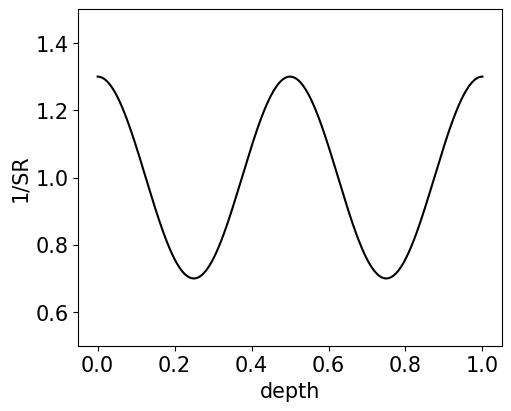

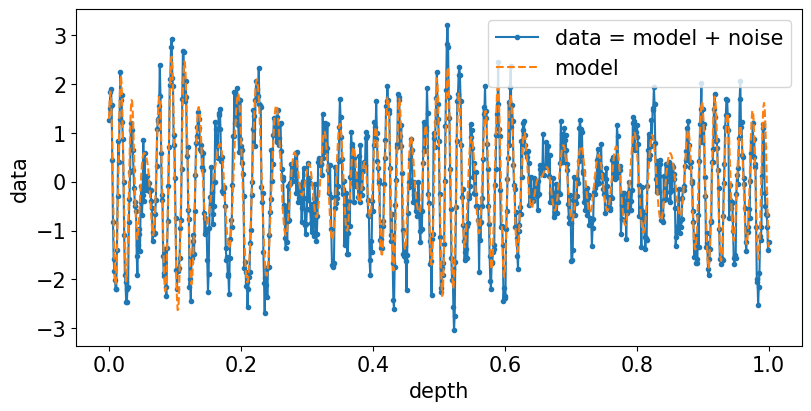

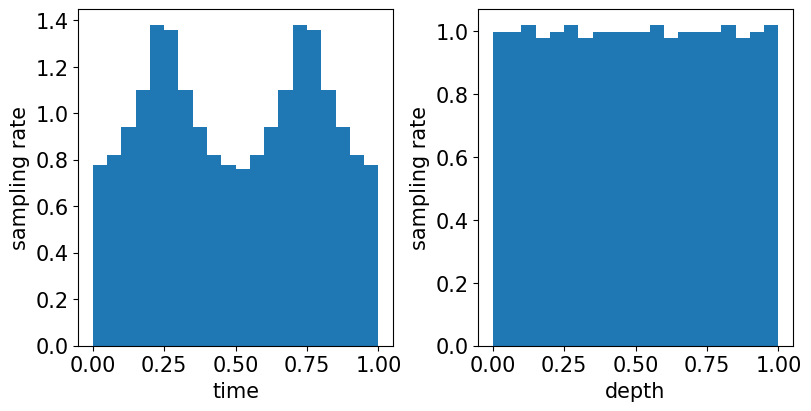

In [4]:
"plot"
# plt.subplots(1,2)
plt.figure(figsize=(5,4), constrained_layout=True)
plt.subplot(1,1,1)
plt.plot(depth, invSR, color="black")
# plt.ylim([0,2])
plt.ylim([0.5,1.5])

plt.xlabel("depth")
plt.ylabel("1/SR")
# plt.subplot(1,2,2)
# plt.xlabel("depth")
# plt.ylabel("time")
# plt.plot(depth, time, color="black")
plt.savefig("figures/invSR_sinek3.png",dpi=200)


plt.figure(figsize=(8,4), constrained_layout=True)
plt.plot(depth, y, '.-', label="data = model + noise")
plt.plot(depth, y_model,'--', label="model")
plt.xlabel("depth")
plt.ylabel("data")
plt.legend()
# plt.savefig("figures/data_sinek3.png",dpi=200)
# plt.figure(figsize=(15,4))
# plt.plot(time, y)
# plt.plot(time, y_model,'--')
# plt.scatter(time, np.ones_like(time)*-4, s=0.1, color="black")
# plt.xlabel("time")
# plt.ylabel("data")

plt.figure(figsize=(8,4), constrained_layout=True)
n = 2
plt.subplot(1,n,1)
plt.hist(time, bins=20, density=True)
plt.ylabel("sampling rate")
plt.xlabel("time")
plt.subplot(1,n,2)
plt.hist(depth, bins=20, density=True)
plt.ylabel("sampling rate")
plt.xlabel("depth")

# GA

In [5]:
class invSRinference(ElementwiseProblem):

    def __init__(self, depth_genes, genes_lims, interpolator, data, fs, n_pieces=1, metric=metric):

        self.invSR_lims = genes_lims
        self.depth_genes = depth_genes 
        self.interpolator = interpolator
        self.data = data
        self.fs = fs

        N_genes = len(depth_genes)
        xl = np.zeros(N_genes) + genes_lims[0]
        xu = np.zeros(N_genes) + genes_lims[1]
        self.func_metric = partial(metric, data=data, fs=fs, interpolator=interpolator, n_pieces=n_pieces)
        super().__init__(n_var=N_genes, n_obj=n_pieces, xl=xl, xu=xu)

    def _evaluate(self, genes, out, *args, **kwargs):
        
        out["F"] = -self.func_metric([self.depth_genes, genes])


In [6]:
N_population = 128 # number of individual in population 
N_generations_max = 100
N_genes = 8 # number of intial gene in an individial of the population 
depth_genes = np.linspace(0,1,N_genes)
true_genes = func_inv_SR(depth_genes)
invSR_lims = [0, 2]
fs = muy_k + p0
# fs =  np.array([f1, f2])
# interpolator = interpolate_Akima
interpolator = interpolate_CubicSpline
n_pieces = 2
metric_optimal = metric_piecewise([depth_genes, func_inv_SR(depth_genes)], [depth, y], fs, interpolator, n_pieces)
print(metric_optimal)
# invSR_all = np.zeros((N_generations_max, N_population, N_genes))
# invSR_ini = np.random.rand(N_population, N_genes)*invSR_lims[1]
# invSR_all[0] = invSR_ini
# metric_all = np.zeros((N_generations_max, N_population))
# metric_ini = np.array([metric([depth_genes, invSR_ini_i], [depth, y], fs, interpolator, metric_type="BIC") for invSR_ini_i in invSR_ini])
# metric_all[0] = metric_ini
interpolator = interpolate_CubicSpline
data = [depth, y]
problem = invSRinference(depth_genes, invSR_lims, interpolator, data, fs, n_pieces=n_pieces, metric=metric_piecewise)
out = {}
problem._evaluate(func_inv_SR(depth_genes), out)
out

[0.79530082 0.78220666]


{'F': array([-0.79530082, -0.78220666])}

In [7]:



algorithm = NSGA2(
    pop_size=200,
    n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

termination = get_termination("n_gen", 200)

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

X = res.X
F = res.F

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      200 |      5 |             - |             -
     2 |      300 |      5 |  0.4563824863 |         ideal
     3 |      400 |      8 |  0.0427871671 |             f
     4 |      500 |      7 |  0.0057701607 |         ideal
     5 |      600 |     10 |  0.0668690604 |             f
     6 |      700 |      8 |  0.0557099300 |             f
     7 |      800 |      9 |  0.0344726288 |             f
     8 |      900 |      7 |  0.0353008969 |             f
     9 |     1000 |      8 |  0.0523922887 |         ideal
    10 |     1100 |      4 |  0.1864910465 |         ideal
    11 |     1200 |      5 |  0.4519545993 |         ideal
    12 |     1300 |      4 |  0.1121516165 |             f
    13 |     1400 |      4 |  0.000000E+00 |             f
    14 |     1500 |      2 |  0.3629930581 |         ideal
    15 |     1600 |      2 |  0.000000E+00 |             f
    16 |     1700 |      3 |  0.3126373161 |         ide

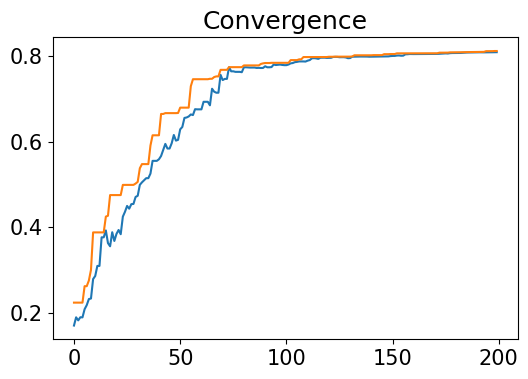

In [9]:
# opt = -np.array([e.opt[0].F for e in res.history])
opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
opt_max = np.array([ np.max(np.mean(np.array([-eiopt.F for eiopt in e.opt]), axis=1)) for e in res.history])

plt.figure()
plt.title("Convergence")
# plt.plot(opt.mean(axis=1), "--")
plt.plot(opt_mean)
plt.plot(opt_max)

# plt.yscale("log")
plt.show()

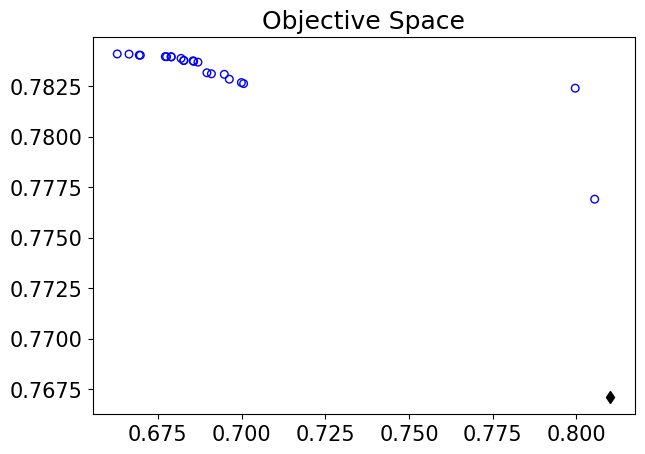

In [103]:
plt.figure(figsize=(7, 5))
plt.scatter(-res.F[:, 0], -res.F[:, 1], s=30, facecolors='none', edgecolors='blue')
f1min, f1max = -res.F[:,0].min(), -res.F[:,0].max()
f1grid = np.linspace(0, 1, 100)

# for i in range(res.F.shape[0]):
#     plt.plot(f1grid, -res.F[i,0] + -res.F[i,1] - f1grid, color="black",alpha=0.5)
plt.title("Objective Space")
# plt.xlim([0,1])
# plt.ylim([0,1])
plt.plot(metric_optimal[0],metric_optimal[1], "d", color="black")
plt.show()


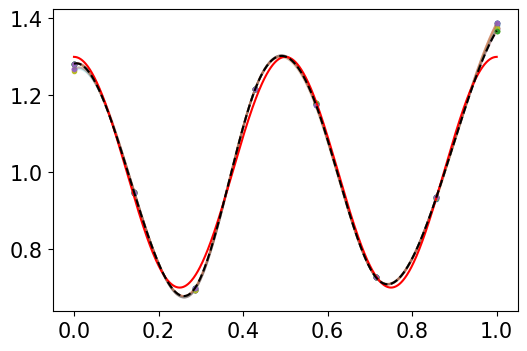

In [8]:
# invSR_interpolate = interpolator([depth_genes, invSR_best], depth)
res.F.shape, res.X.shape
arg_best = np.argmin(res.F.sum(axis=1)/2)
invSR_best = res.X[arg_best]

for i in range(res.F.shape[0]):
    plt.plot(depth_genes, res.X[i], '.')
    invSR_interpolate = interpolator([depth_genes, res.X[i]], depth)
    plt.plot(depth, invSR_interpolate, alpha=0.2)
plt.plot(depth, invSR, color="red")
plt.plot(depth, interpolator([depth_genes, invSR_best], depth), "--", color="black")
# invSR_interpolate[invSR_interpolate<0] = 0

# time = sp.integrate.cumulative_trapezoid(invSR_interpolate, depth, initial=0)
# X = generate_X_linReg(np.ones_like(fs), fs, time)

# reg_model = LinearRegression().fit(X, y_data)
# y_pred = reg_model.predict(X)

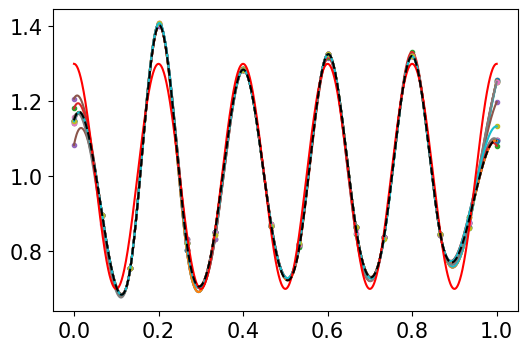

In [157]:
# invSR_interpolate = interpolator([depth_genes, invSR_best], depth)
res.F.shape, res.X.shape
arg_best = np.argmin(res.F.sum(axis=1)/2)
invSR_best = res.X[arg_best]

for i in range(res.F.shape[0]):
    plt.plot(depth_genes, res.X[i], '.')
    invSR_interpolate = interpolator([depth_genes, res.X[i]], depth)
    plt.plot(depth, invSR_interpolate)
plt.plot(depth, invSR, color="red")
plt.plot(depth, interpolator([depth_genes, invSR_best], depth), "--", color="black")
# invSR_interpolate[invSR_interpolate<0] = 0

# time = sp.integrate.cumulative_trapezoid(invSR_interpolate, depth, initial=0)
# X = generate_X_linReg(np.ones_like(fs), fs, time)

# reg_model = LinearRegression().fit(X, y_data)
# y_pred = reg_model.predict(X)

In search for optimal number of genes

In [32]:
algorithm = NSGA2(
    pop_size=200,
    n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)
N_generations = 200
termination = get_termination("n_gen", N_generations)
N_genes_enemble = np.arange(2, 22, 1)
depth_genes_ensemble = [np.linspace(0,1,N_genes) for N_genes in N_genes_enemble] 
N_ensemble = len(depth_genes_ensemble)

problems = [invSRinference(depth_genes, invSR_lims, interpolator, data, fs, n_pieces=n_pieces, metric=metric_piecewise) for depth_genes in depth_genes_ensemble  ] 


res_ensemble = Parallel(n_jobs=N_ensemble, verbose=100)(delayed(minimize)(problem, algorithm, termination, save_history=True) for problem in problems)


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:  1.4min remaining: 12.9min
[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:  1.6min remaining:  8.9min
[Parallel(n_jobs=20)]: Done   4 out of  20 | elapsed:  1.6min remaining:  6.4min
[Parallel(n_jobs=20)]: Done   5 out of  20 | elapsed:  1.7min remaining:  5.1min
[Parallel(n_jobs=20)]: Done   6 out of  20 | elapsed:  1.7min remaining:  4.0min
[Parallel(n_jobs=20)]: Done   7 out of  20 | elapsed:  1.8min remaining:  3.3min
[Parallel(n_jobs=20)]: Done   8 out of  20 | elapsed:  1.8min remaining:  2.7min
[Parallel(n_jobs=20)]: Done   9 out of  20 | elapsed:  1.9min remaining:  2.3min
[Parallel(n_jobs=20)]: Done  10 out of  20 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=20)]: Done  11 out of  20 | elapsed:  1.9min remaining:  1.6min
[Parallel(n_jobs=20)]: Done  12 out of  20 | elapse

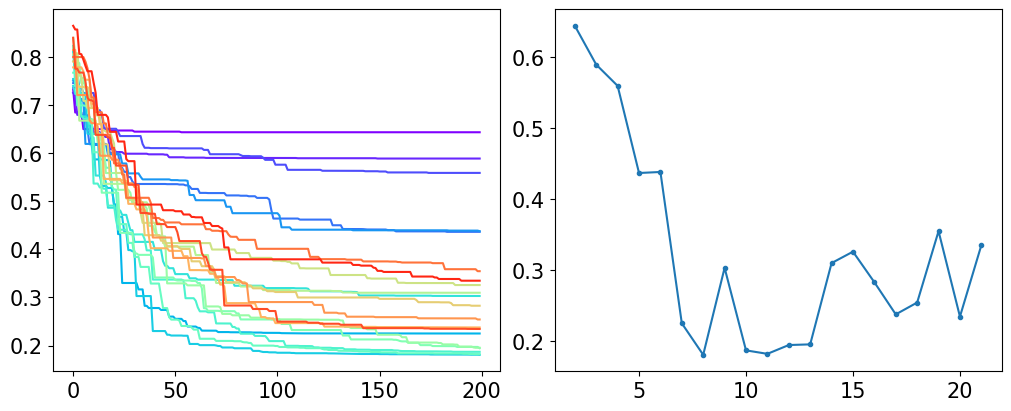

In [42]:
# opt = -np.array([e.opt[0].F for e in res.history])
# opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])

plt.figure(figsize=(10, 4), constrained_layout=True)
plt.title("Convergence")
plt.subplot(1,2,1)

cmap = plt.get_cmap("rainbow")

opt_max_ensemble = np.zeros([N_ensemble,N_generations])
for i in range(N_ensemble):
    res = res_ensemble[i]
    opt_max_ensemble[i] = np.array([ np.max(np.mean(np.array([-eiopt.F for eiopt in e.opt]), axis=1)) for e in res.history])

    # plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))
    plt.plot(1-opt_max_ensemble[i], color=cmap(i/N_ensemble))

# plt.yscale("log")
plt.subplot(1,2,2)
plt.plot(N_genes_enemble, 1-opt_max_ensemble[:,-1], '.-')

# MCMC

## In search for SR
(frequencies are presumed to be known constant)

In [233]:
log_likelihood_rednoise([depth_genes, true_genes], [depth, y], fs, [sigma_true, rho_true]), log_likelihood_rednoise([depth_genes, true_genes], [depth, y], fs, [0.5, 0.1])

(351.6261472456196, 239.344859145508)

In [218]:
# %lprun -f log_likelihood_AR1 log_likelihood_AR1([depth_genes, true_genes], [depth, y], fs, [0.5, 0.1])

In [ ]:
arg_best = np.argmin(res.F.sum(axis=1)/2)
invSR_best = res.X[arg_best]
invSR_random = np.random.randn(N_genes)*(invSR_lims[1]-invSR_lims[0]) + invSR_lims[0]

nwalkers = 64
pos = invSR_best + 1e-4 * np.random.randn(nwalkers, N_genes)
# pos = invSR_random + 1e-4 * np.random.randn(nwalkers, N_genes)

nwalkers, ndim = pos.shape

log_probability_testcase = partial(log_posterior, depth_invSR=depth_genes, data=[depth, y], fs=fs, sigma=sigma_true, interpolator=interpolate_CubicSpline, invSR_lims=invSR_lims) 


with Pool(processes=1) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_testcase, pool=pool)
    sampler.run_mcmc(pos, 2000, progress=True)
    # print("Multiprocessing took {0:.1f} seconds".format(multi_time))


In [206]:
arg_best = np.argmin(res.F.sum(axis=1)/2)
invSR_best = res.X[arg_best]
invSR_random = np.random.randn(N_genes)*(invSR_lims[1]-invSR_lims[0]) + invSR_lims[0]

nwalkers = 32
params_noise_ini = [0.7, 0.7]
params_ini = np.hstack([params_noise_ini, invSR_best])
pos = params_ini + 1e-4 * np.random.randn(nwalkers, N_genes+len(params_noise_ini))
# pos = invSR_random + 1e-4 * np.random.randn(nwalkers, N_genes)

nwalkers, ndim = pos.shape
log_posterior = log_posterior_rednoise_v1
log_probability_testcase = partial(log_posterior, depth_invSR=depth_genes, data=[depth, y], fs=fs, interpolator=interpolate_CubicSpline, invSR_lims=invSR_lims) 


with Pool(processes=16) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_testcase, pool=pool)
    sampler.run_mcmc(pos, 10000, progress=True)
    # print("Multiprocessing took {0:.1f} seconds".format(multi_time))

100%|██████████| 10000/10000 [03:02<00:00, 54.67it/s]


In [207]:
print("acceptance_fraction", sampler.acceptance_fraction.mean())
tau = sampler.get_autocorr_time()
print("autocorr_time",tau)

acceptance_fraction 0.418765625


AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [212.39119921 207.16756476  95.18468131  97.48549144 100.1338835
  96.82899663 102.56987841 118.59689287 125.49975584 114.32409323]

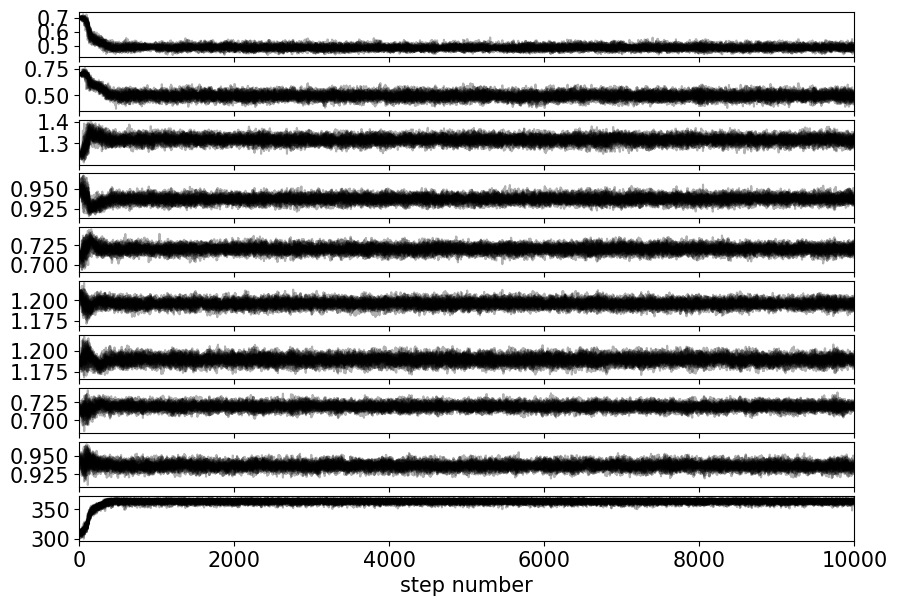

In [208]:
ndim = 10
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
logprob_sample = sampler.get_log_prob()

# labels = ["m", "b", "log(f)"]
for i in range(ndim-1):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    # ax.set_ylabel(labels[i])
    # ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].plot(logprob_sample, "k", alpha=0.3)
axes[-1].set_xlabel("step number");     

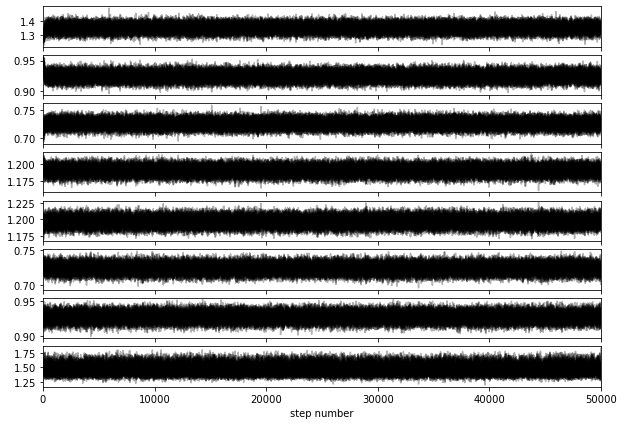

In [261]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
# labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    # ax.set_ylabel(labels[i])
    # ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");     

In [212]:
flat_samples = sampler.get_chain(discard=1000, thin=50, flat=True)
print(flat_samples.shape)

(5760, 10)


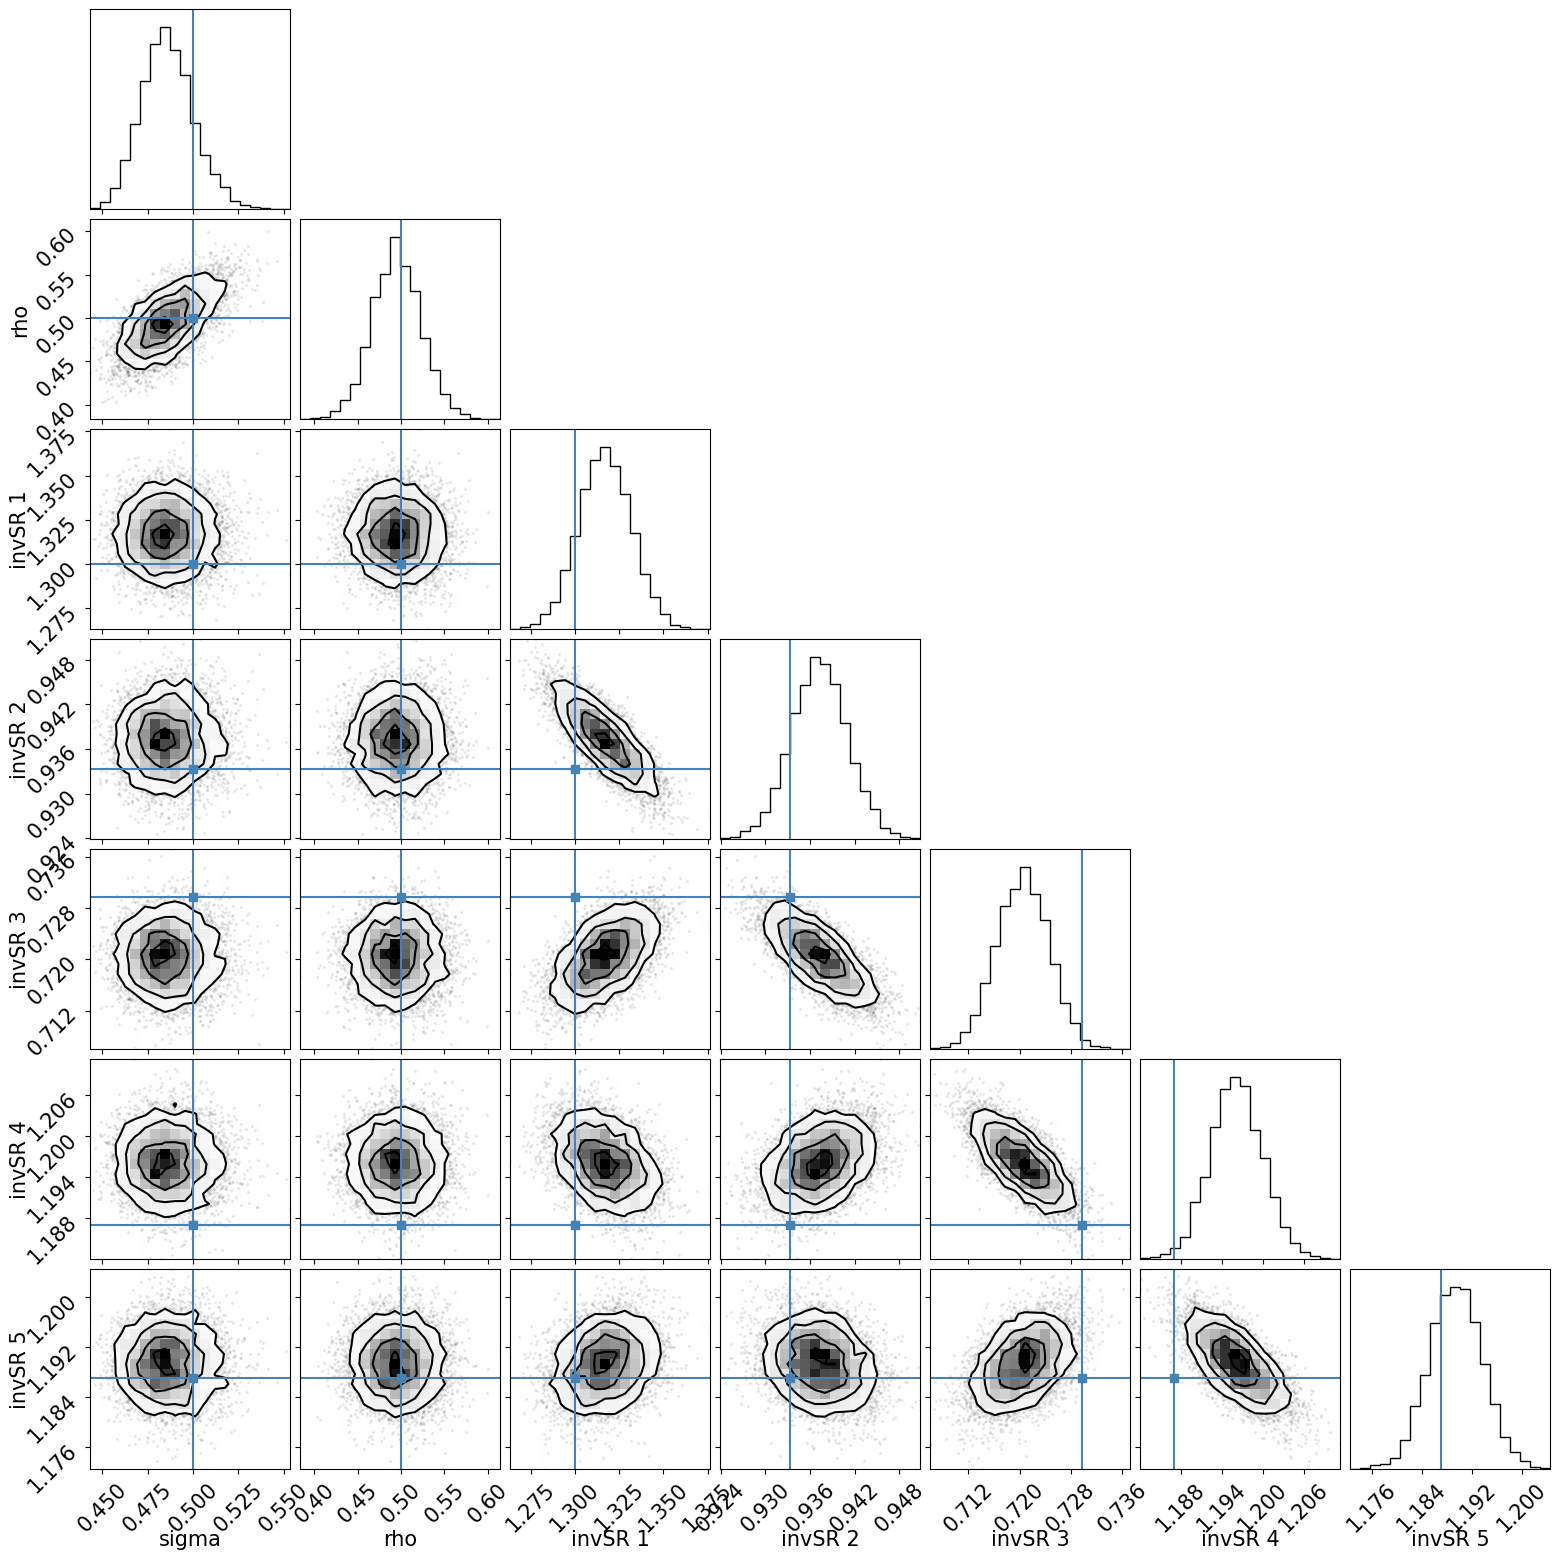

In [213]:
# labels = list(map(r"invSR{0}".format, range(1, N_genes + 1)))
# n_genes_plot = N_genes
n_genes_plot = 5
true_values = np.hstack([[sigma_true, rho_true], true_genes[:n_genes_plot]])
labels = ["sigma", "rho"] + [f"invSR {i}" for i in range(1,n_genes_plot+1)]
fig = corner.corner(
    flat_samples[:,:n_genes_plot+2], truths=true_values, labels=labels
)

# corner.overplot_lines(fig, invSR_best[:n_genes_plot], color="C1",label="GA")
# corner.overplot_points(fig, invSR_best[None,:n_genes_plot], marker="s", color="C1")
# plt.legend()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


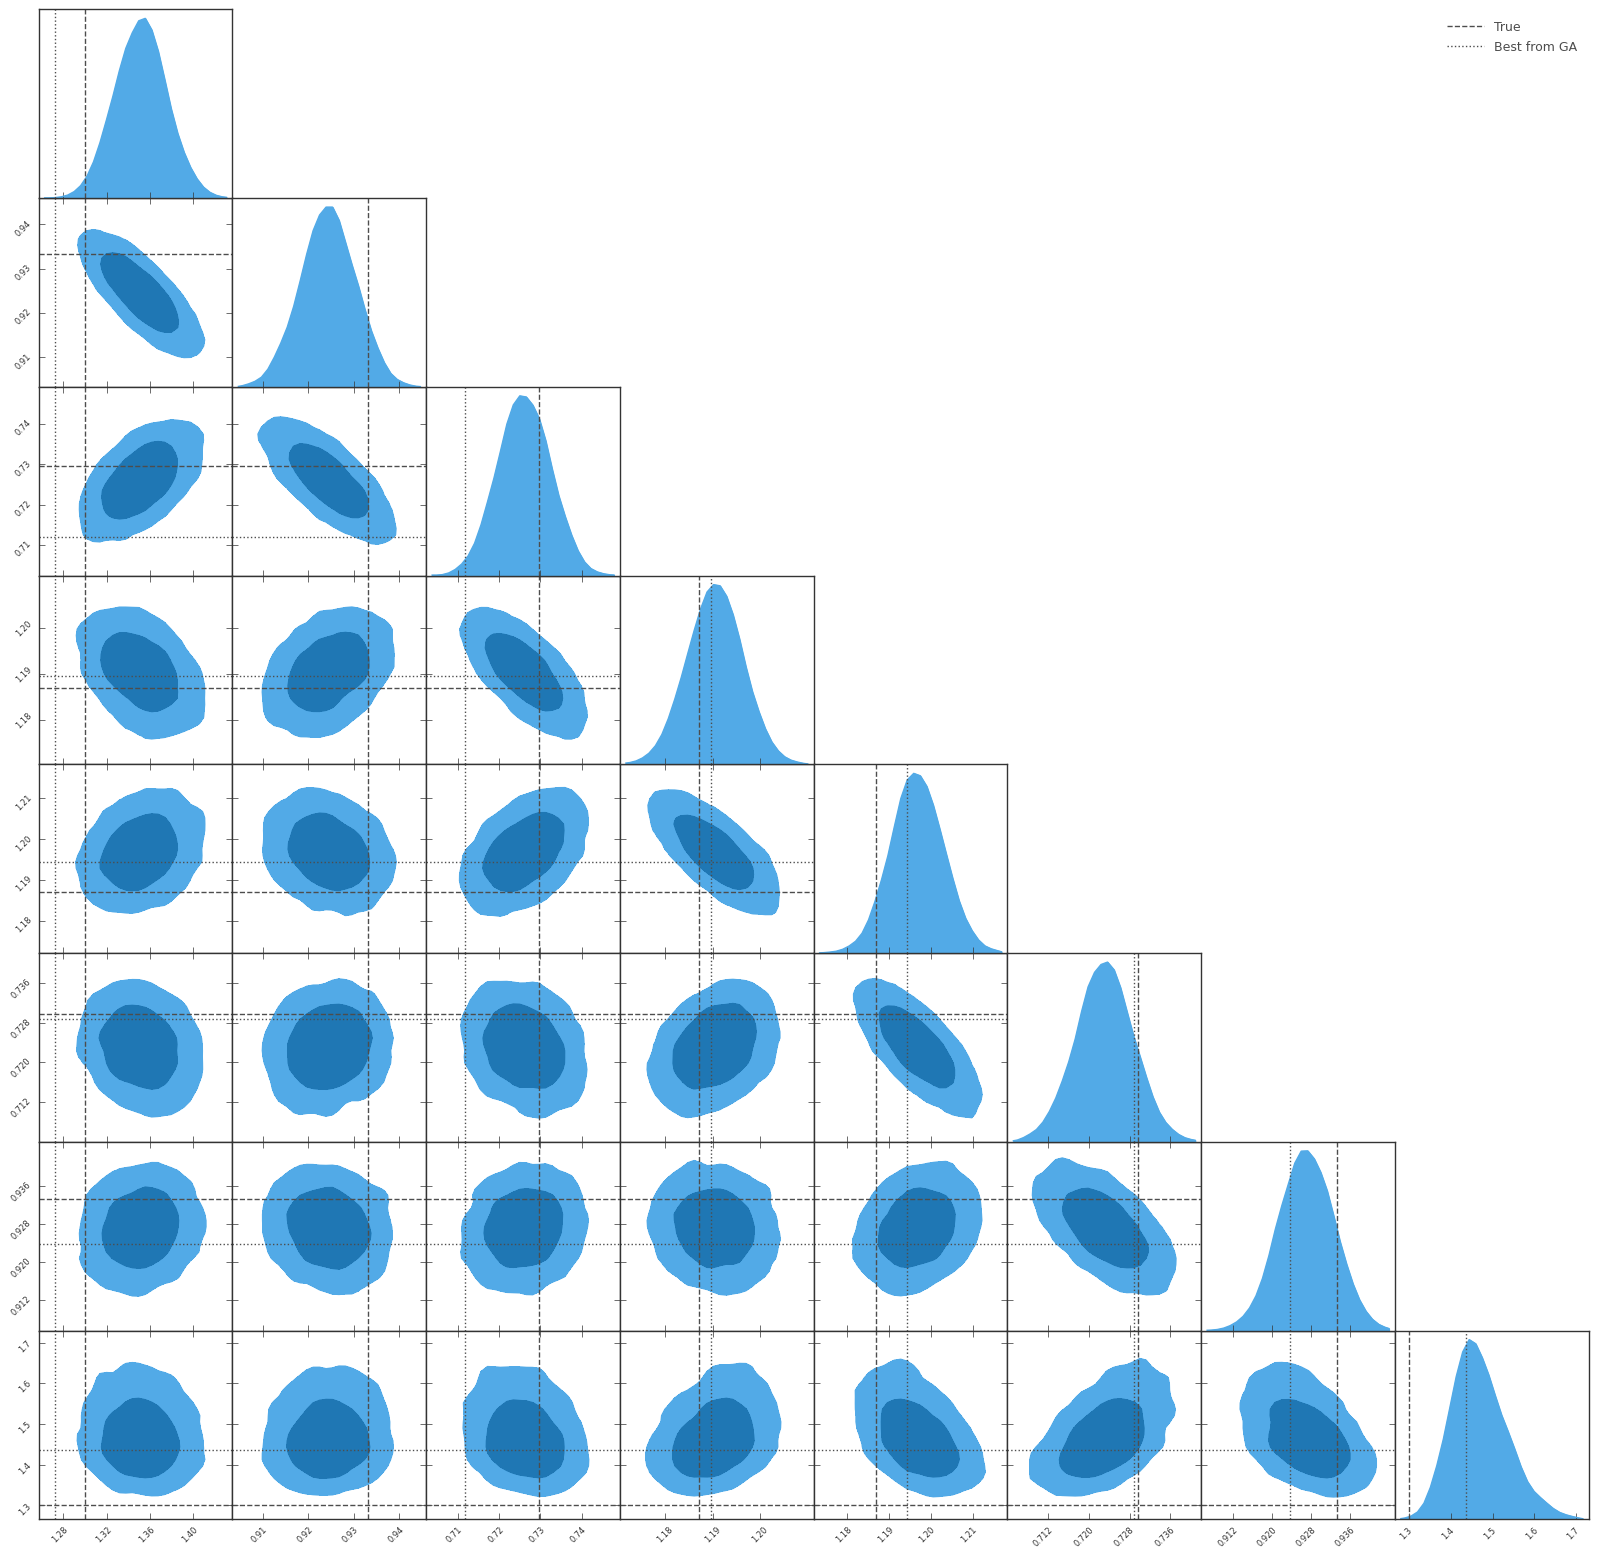

In [91]:
# fig = corner.corner(
#     flat_samples, truths=func_inv_SR(depth_genes)
# )
truthLabels = ["True", "Best from GA"]
GTC = pygtc.plotGTC(chains=[flat_samples],
                    # paramNames=names,
                    # chainLabels=chainLabels,
                    truths= [func_inv_SR(depth_genes), invSR_best],
                    truthLabels=truthLabels,
                    figureSize = 20,
                    # figureSize='AandA_page'
                    )
# corner.overplot_lines(fig, invSR_best, color="C1")
# corner.overplot_points(fig, invSR_best[None], marker="s", color="C1")

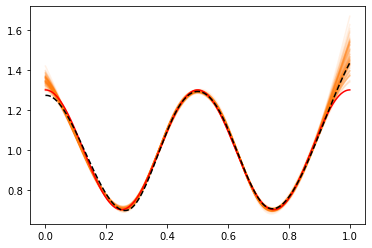

In [267]:
# invSR_interpolate = interpolator([depth_genes, invSR_best], depth)
res.F.shape, res.X.shape
arg_best = np.argmin(res.F.sum(axis=1)/2)
invSR_best = res.X[arg_best]
inds = np.random.randint(len(flat_samples), size=100)
for i in inds:
    # plt.plot(depth_genes, flat_samples[i], '.', color="C1")
    invSR_interpolate = interpolator([depth_genes, flat_samples[i]], depth)
    plt.plot(depth, invSR_interpolate , "C1", alpha=0.1)
plt.plot(depth, invSR, color="red")
plt.plot(depth, interpolator([depth_genes, invSR_best], depth), "--", color="black")


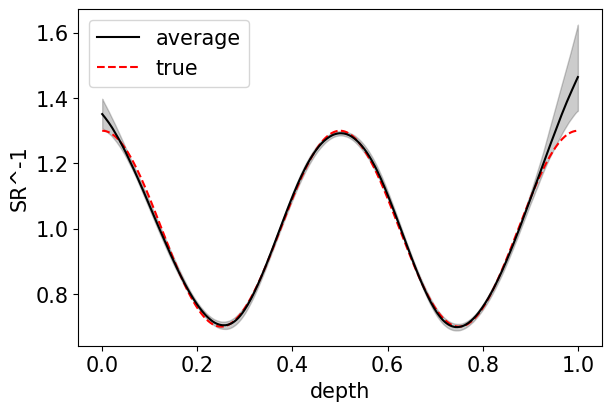

In [95]:
inds = np.random.randint(len(flat_samples), size=1000)
invSR_interpolate_par = np.array([interpolator([depth_genes, flat_samples[i]], depth) for i in inds])
# invSR_interpolate_par = invSR_interpolate_par[metric_best<500]

# invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.025, 0.975],axis=0)

fig1 = plt.figure(constrained_layout=True)
# plt.title(f"estimation from {n_para} populations")
plt.plot(depth, mean_invSR, zorder=10,color="black", label="average")
# plt.plot(depth, best_invSR, "--",color="black", label="best", zorder=10)

plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black")
plt.plot(depth, invSR, "--", color="red", label="true")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()

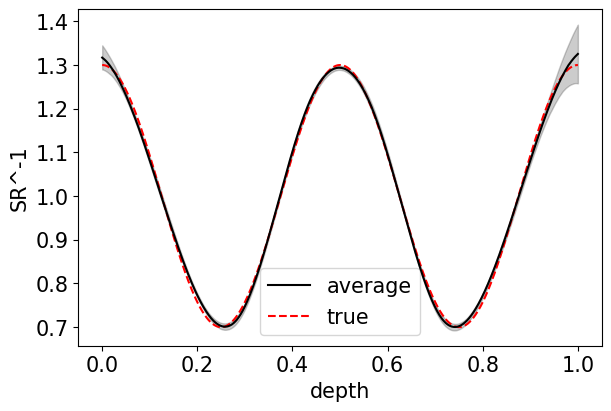

In [215]:
inds = np.random.randint(len(flat_samples), size=1000)
invSR_interpolate_par = np.array([interpolator([depth_genes, flat_samples[i,2:]], depth) for i in inds])
# invSR_interpolate_par = invSR_interpolate_par[metric_best<500]

# invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.025, 0.975],axis=0)

fig1 = plt.figure(constrained_layout=True)
# plt.title(f"estimation from {n_para} populations")
plt.plot(depth, mean_invSR, zorder=10,color="black", label="average")
# plt.plot(depth, best_invSR, "--",color="black", label="best", zorder=10)

plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black")
plt.plot(depth, invSR, "--", color="red", label="true")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()

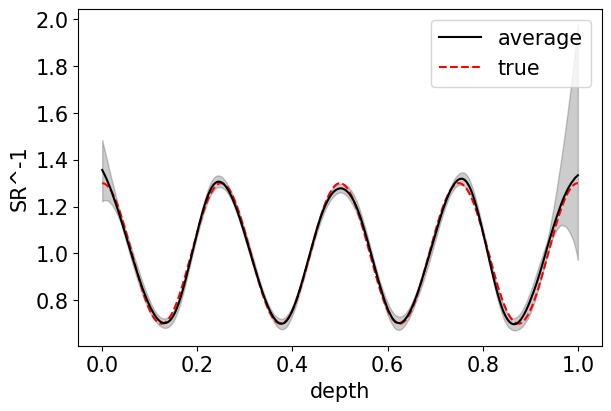

In [145]:
inds = np.random.randint(len(flat_samples), size=1000)
invSR_interpolate_par = np.array([interpolator([depth_genes, flat_samples[i]], depth) for i in inds])
# invSR_interpolate_par = invSR_interpolate_par[metric_best<500]

# invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.025, 0.975],axis=0)

fig1 = plt.figure(constrained_layout=True)
# plt.title(f"estimation from {n_para} populations")
plt.plot(depth, mean_invSR, zorder=10,color="black", label="average")
# plt.plot(depth, best_invSR, "--",color="black", label="best", zorder=10)

plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black")
plt.plot(depth, invSR, "--", color="red", label="true")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()

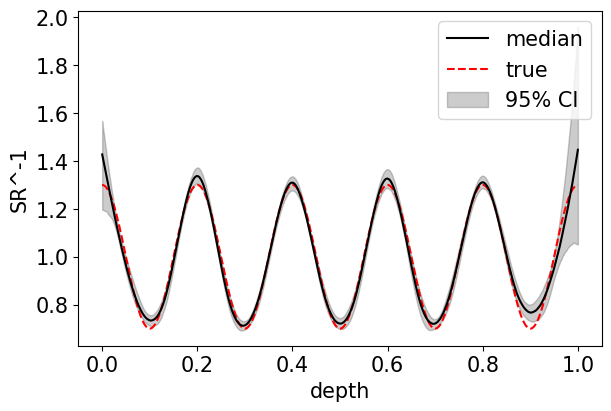

In [187]:
inds = np.random.randint(len(flat_samples), size=1000)
invSR_interpolate_par = np.array([interpolator([depth_genes, flat_samples[i]], depth) for i in inds])
# invSR_interpolate_par = invSR_interpolate_par[metric_best<500]

# invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.025, 0.975],axis=0)

fig1 = plt.figure(constrained_layout=True)
# plt.title(f"estimation from {n_para} populations")
plt.plot(depth, mean_invSR, zorder=10,color="black", label="median")
plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black", label="95% CI")

# plt.plot(depth, best_invSR, "--",color="black", label="best", zorder=10)

plt.plot(depth, invSR, "--", color="red", label="true")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()
# plt.savefig("figures/invSR_sinek10.png")

## In search for frequencies

In [272]:
def log_posterior_whitenoise(params, depth_invSR, data, prior_params_freq, interpolator=interpolate_CubicSpline, invSR_lims=[0,2],
                             sigma_lims=[1e-4, 2]):
    """ same as log_posterior_whitenoise_v1 but frequencies are no longer constant but treated as parameters
    params: array[1 + N_genes] = [sigma, rho (from AR1), array of invSR]
    prior_freq: array[N_freq, 2] :  parameters of prior for frequencies fs, (Gaussian with muy and sigma as params) 
    """
    sigma =  params[0]
    N_freq = len(prior_params_freq)
    freqs = params[1:1+N_freq]
    fs = freqs[0] + freqs[1:]
    invSR = params[1+N_freq:]
    # print(freqs, sigma, invSR)
    
    lp_invSR = log_uniform(invSR, invSR_lims)
    lp_sigma = log_loguniform(sigma, sigma_lims)    
    lp_fs = sum([log_gaussian(freqs[i], prior_params_freq[i]) for i in range(N_freq) ])
    lp = lp_invSR + lp_sigma + lp_fs
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_whitenoise([depth_invSR, invSR], data, fs, sigma, interpolator=interpolator)

In [43]:
%lprun -f log_likelihood_whitenoise  log_likelihood_whitenoise([depth_genes, invSR_best], data=[depth, y],interpolator=interpolate_CubicSpline, invSR_lims=invSR_lims,  fs=fs, sigma=0.8)         


Timer unit: 1e-09 s

Total time: 0.00770338 s
File: /users/nhoanghoai/AstroGeo/routines_model.py
Function: log_likelihood_whitenoise at line 244

Line #      Hits         Time  Per Hit   % Time  Line Contents
   244                                           def log_likelihood_whitenoise(invSR, data, fs, sigma, interpolator=interpolate_CubicSpline, *args, **kwargs):
   245                                               """_summary_: 
   246                                               
   247                                                   loglikelihood for the linear model with predictors variable are fourier harmonics of frequencies fs
   248                                                   of fitting the data, when used the age model derived from the invSR.
   249                                                   age model: given points of inverse SR, interpolate with an interpolator and integrate along depth
   250                                                   to obtain time.

In [301]:
%lprun -f log_posterior_whitenoise  log_posterior_whitenoise(params_best, depth_invSR=depth_genes, data=[depth, y],interpolator=interpolate_CubicSpline, \
                                   invSR_lims=invSR_lims, sigma_lims=[1e-4, 2], prior_freq=prior_freq)

Timer unit: 1e-09 s

Total time: 0.0116542 s
File: /tmp/ipykernel_341108/405042703.py
Function: log_posterior_whitenoise at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def log_posterior_whitenoise(params, depth_invSR, data, prior_freq, interpolator=interpolate_CubicSpline, invSR_lims=[0,2],
     2                                                                        sigma_lims=[1e-4, 2]):
     3                                               """ same as log_posterior_whitenoise_v1 but frequencies are no longer constant but treated as parameters
     4                                               params: array[1 + N_genes] = [sigma, rho (from AR1), array of invSR]
     5                                               prior_freq: array[N_freq, 2] :  parameters of prior for frequencies fs, (Gaussian with muy and sigma as params) 
     6                                               """
     7         1       7444.

In [323]:
prior_params_freq = np.array([[50.5, 10], [5.525, 0.125], [7.455, 0.015], [17.3, 0.15], [17.85, 0.15], [4.257564, 0.00002]])
prior_params_freq = prior_params_freq/180/3600*np.pi*1e6

In [344]:
log_posterior = log_posterior_whitenoise

arg_best = np.argmin(res.F.sum(axis=1)/2)
invSR_best = res.X[arg_best]
invSR_random = np.random.randn(N_genes)*(invSR_lims[1]-invSR_lims[0]) + invSR_lims[0]

nwalkers = 32
params_noise_ini = [0.5]
params_freq_ini = prior_params_freq[:,0]
params_ini = np.hstack([params_noise_ini, params_freq_ini, invSR_best])
params_best = np.hstack([sigma_true, p0, muy_k, true_genes])
pos_ini = params_ini + 1e-4 * np.random.randn(nwalkers, len(params_ini))
# pos = invSR_random + 1e-4 * np.random.randn(nwalkers, N_genes)

nwalkers, ndim = pos_ini.shape
log_probability_testcase = partial(log_posterior, depth_invSR=depth_genes, data=[depth, y],interpolator=interpolate_CubicSpline,
                                   invSR_lims=invSR_lims, sigma_lims=[1e-4, 2], prior_freq=prior_params_freq) 

print(f"log posterior initial point: {log_probability_testcase(pos_ini[0])}")
print(f"log posterior best point: {log_probability_testcase(params_best)}")


with Pool(processes=1) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_testcase, pool=pool)
    sampler.run_mcmc(pos_ini, 5000, progress=True)


log posterior initial point: 26.079059366917164
log posterior best point: 88.66482377222958


100%|██████████| 5000/5000 [06:15<00:00, 13.31it/s]


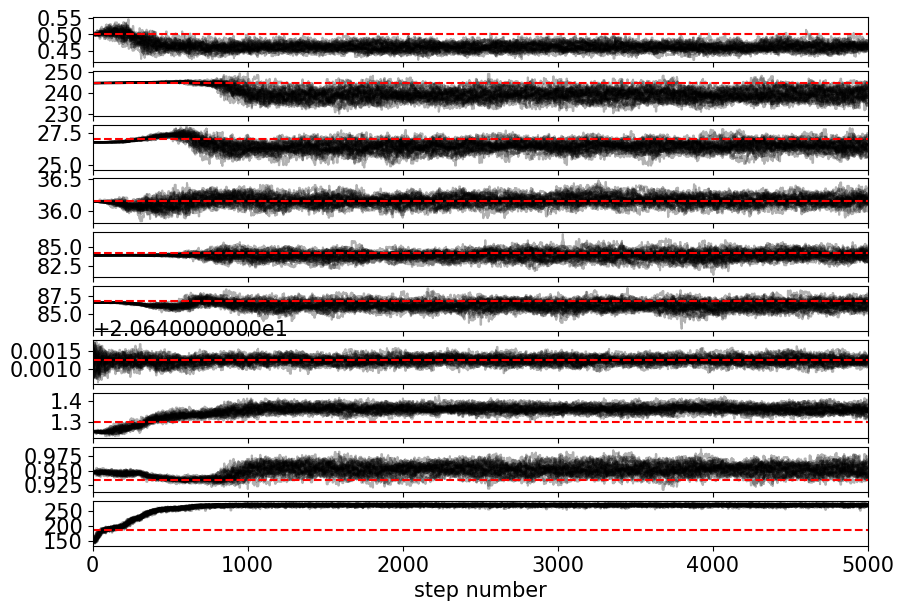

In [309]:
ndim = 10
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
logprob_sample = sampler.get_log_prob()

# labels = ["m", "b", "log(f)"]
for i in range(ndim-1):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.axhline(params_best[i], ls="--", color="red")
    # ax.set_ylabel(labels[i])
    # ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].plot(logprob_sample, "k", alpha=0.3)
axes[-1].axhline(log_probability_testcase(params_best), ls="--", color="red")
axes[-1].set_xlabel("step number");     

In [310]:
print("acceptance_fraction", sampler.acceptance_fraction.mean())
tau = sampler.get_autocorr_time()
print("autocorr_time",tau)

acceptance_fraction 0.34630625


AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 15 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [226.60862057 384.73220764 229.49598819 147.92720911 175.89973779
 149.60244243 139.66973698 425.91316656 276.15981944 399.93719823
 351.72993722 371.42451505 384.73419768 245.01554967 413.94645666]

In [312]:
# tau = sampler.get_autocorr_time()
# burnin = int(2 * np.max(tau))
# thin = int(0.5 * np.min(tau))
flat_samples = sampler.get_chain(discard=1000, thin=50, flat=True)
print(flat_samples.shape)

(2560, 15)


In [335]:
freqs_true

array([244.67440141,  27.04958786,  36.15093207,  84.1956285 ,
        86.83107083,  20.64125275])

(45.0, 55.0)

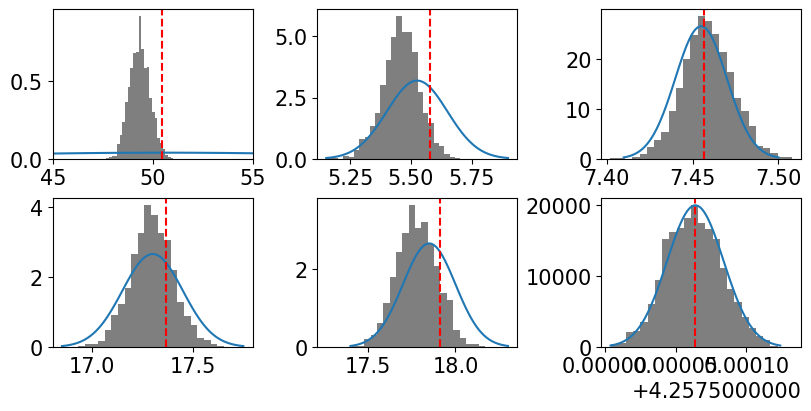

In [345]:
fig, axs = plt.subplots(2,3, figsize=(8,4),constrained_layout=True)
coef = 1/180/3600*np.pi*1e6
for i, ax in enumerate(axs.flatten()):

    # variance = 1
    # sigma = math.sqrt(variance)
    muy, sigma = prior_params_freq[i]/coef
    x = np.linspace(muy - 3*sigma, muy + 3*sigma, 100)
    ax.plot(x, sp.stats.norm.pdf(x, muy, sigma))
    ax.hist(flat_samples[:,1+i]/coef, density=True, color="k", alpha=0.5, bins=25)
    ax.axvline(freqs_true[i]/coef, ls="--", color="red")
axs[0,0].set_xlim(45,55)

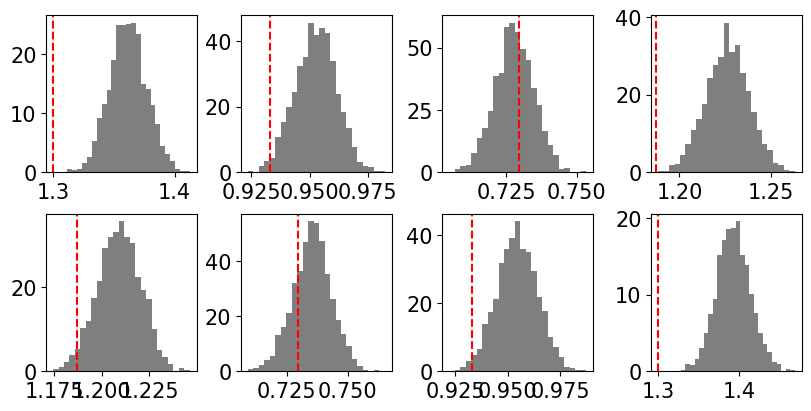

In [352]:
fig, axs = plt.subplots(2,N_genes//2, figsize=(8,4),constrained_layout=True)
for i, ax in enumerate(axs.flatten()):
    # variance = 1
    # sigma = math.sqrt(variance)
    # muy, sigma = prior_params_freq[i]/coef
    # x = np.linspace(muy - 3*sigma, muy + 3*sigma, 100)
    # ax.plot(x, sp.stats.norm.pdf(x, muy, sigma))
    ax.hist(flat_samples[:,1+len(freqs_true)+i], density=True, color="k", alpha=0.5, bins=25)
    ax.axvline(true_genes[i], ls="--", color="red")
# axs[0,0].set_xlim(45,55)

In [358]:
flat_samples.shape

(2560, 15)

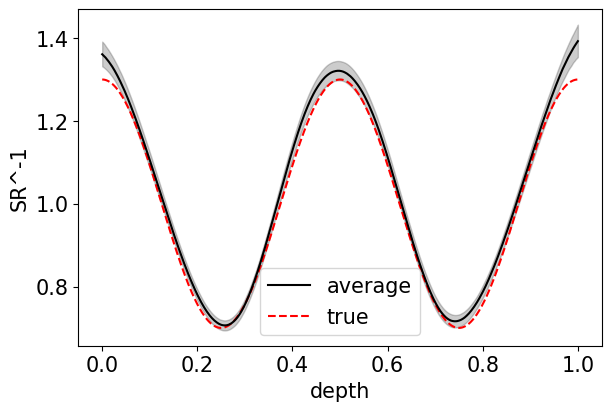

In [357]:
inds = np.random.randint(len(flat_samples), size=1000)
# genes_value = flat_samples[:,1+len(freqs_true)+i]
invSR_interpolate_par = np.array([interpolator([depth_genes, flat_samples[i,1+len(freqs_true):]], depth) for i in inds])
# invSR_interpolate_par = invSR_interpolate_par[metric_best<500]

# invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.025, 0.975],axis=0)

fig1 = plt.figure(constrained_layout=True)
# plt.title(f"estimation from {n_para} populations")
plt.plot(depth, mean_invSR, zorder=10,color="black", label="average")
# plt.plot(depth, best_invSR, "--",color="black", label="best", zorder=10)

plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black")
plt.plot(depth, invSR, "--", color="red", label="true")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()